# Here we will plot the slope and the knee frqeuency per subject for each sleep stage 

In [122]:
import os
from pathlib import Path
import numpy as np
import mne
import pandas as pd
import glob
import json
# Use neurodsp for convenience
from neurodsp.plts import plot_time_series, plot_power_spectra
from neurodsp.spectral import compute_spectrum

# Import fooof for checking model fits
from fooof import FOOOF
from fooof import FOOOFGroup

# KNEE freqs
from fooof.utils.params import compute_knee_frequency
from fooof.utils.download import load_fooof_data

# Plotting functions
from spiketools.plts.utils import make_axes
import matplotlib.pyplot as plt
import seaborn

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("/home/b1044271/Columbia/Aperiodic_sleep/Aperiodic_sleep_paper/helpers")

# GET PATHS

In [2]:
# get the staging list
path_stage = Path('/home/b1044271/EEGsleep/SleepStaging/mat/mne2/')
stage_files = os.listdir(path_stage)
stage_files = [file for file in stage_files]
stage_files = sorted(stage_files)

# get the subjects list
Data_path = '/home/b1044271/Columbia/Preprocessed/Better_ica/'
subj_files = os.listdir(Data_path)
subj_files = [file for file in subj_files]
subj_files = sorted(subj_files)


# Setting parameters

In [3]:
# Settings for the analyses
SETTINGS_B = { 'method' : 'welch', 'average' : 'mean', 'fmin' :0.1, 'fmax': 45}
path_results = Path('/home/b1044271/Columbia/Results/April23')

f_min = 1
f_max = 45
t     = 15
fs    = 250

SETTINGS_W  = { 'method' : 'welch', 'average' : 'mean', 'fmin' :f_min , 'fmax':f_max, 'n_fft': fs*t, 'n_overlap': fs*t*0.5}
SETTINGS_F1 = {'max_n_peaks':8, 'aperiodic_mode':'knee'}
SETTINGS_F2 = {'max_n_peaks':8, 'aperiodic_mode':'fixed'}


# Empty vectors for storing data

In [4]:
W_Kn  = np.zeros([183,2000])*np.nan
W_Exp = np.zeros([183,2000])*np.nan
W_Exp2 = np.zeros([183,2000])*np.nan

N1_Kn  = np.zeros([183,2000])*np.nan
N1_Exp = np.zeros([183,2000])*np.nan
N1_Exp2 = np.zeros([183,2000])*np.nan

N2_Kn  = np.zeros([183,2000])*np.nan
N2_Exp = np.zeros([183,2000])*np.nan
N2_Exp2 = np.zeros([183,2000])*np.nan

N3_Kn  = np.zeros([183,2000])*np.nan
N3_Exp = np.zeros([183,2000])*np.nan
N3_Exp2 = np.zeros([183,2000])*np.nan

R_Kn  = np.zeros([183,2000])*np.nan
R_Exp = np.zeros([183,2000])*np.nan
R_Exp2 = np.zeros([183,2000])*np.nan


# START Looping over subjects

In [6]:
# Helper function for paths, check for the path and creates ones if not found
def check_path(path):
    if not os.path.exists(path):
        os.mkdir(path)

check_path(path_results) # create a new folder for this analysis

In [7]:
# Start function
i = 0
for x in subj_files:
    check_path(path_results / x[0:4]) # create subject folder
    EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
    print('loaded')
    
    events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers
    epochs = mne.Epochs(EEG, events=events, tmin=-30, tmax=0)

#Now we select epochs and average over all epochs
    N1s = epochs['1']
    N2s = epochs['2']
    N3s = epochs['3']
    REs = epochs['5']
    AWs = epochs['0']
    
# Settings for PSD calculation using welch's
    N1={}
    N2={}
    N3={}
    AW={}
    RM={}

# calculate psd based on welch's method with differen freq range and diff time steps
    N1 = N1s.compute_psd(**SETTINGS_W) #N1
    N2 = N2s.compute_psd(**SETTINGS_W) #N2
    N3 = N3s.compute_psd(**SETTINGS_W)
    AW = AWs.compute_psd(**SETTINGS_W)
    RM = REs.compute_psd(**SETTINGS_W)
    
# FOOOF it
    fm1 = FOOOFGroup(**SETTINGS_F1)
    fm1.fit(N1._freqs, np.mean(N1._data,0), [N1._freqs[0] ,N1._freqs[-1]])
    
    fm2 = FOOOFGroup(**SETTINGS_F1)
    fm2.fit(N2._freqs, np.mean(N2._data,0), [N2._freqs[0] ,N2._freqs[-1]])
 
    fm3 = FOOOFGroup(**SETTINGS_F1)
    fm3.fit(N3._freqs, np.mean(N3._data,0), [N3._freqs[0] ,N3._freqs[-1]])
    
    fm4 = FOOOFGroup(**SETTINGS_F1)
    fm4.fit(RM._freqs, np.mean(RM._data,0), [RM._freqs[0] ,RM._freqs[-1]])
    
    fm5 = FOOOFGroup(**SETTINGS_F1)
    fm5.fit(AW._freqs, np.mean(AW._data,0), [AW._freqs[0] ,AW._freqs[-1]])
    
    fm6 = FOOOFGroup(**SETTINGS_F2)
    fm6.fit(N1._freqs, np.mean(N1._data,0), [N1._freqs[0] ,N1._freqs[-1]])
    
    fm7 = FOOOFGroup(**SETTINGS_F2)
    fm7.fit(N2._freqs, np.mean(N2._data,0), [N2._freqs[0] ,N2._freqs[-1]])
 
    fm8 = FOOOFGroup(**SETTINGS_F2)
    fm8.fit(N3._freqs, np.mean(N3._data,0), [N3._freqs[0] ,N3._freqs[-1]])
    
    fm9 = FOOOFGroup(**SETTINGS_F2)
    fm9.fit(RM._freqs, np.mean(RM._data,0), [RM._freqs[0] ,RM._freqs[-1]])
    
    fm10 = FOOOFGroup(**SETTINGS_F2)
    fm10.fit(AW._freqs, np.mean(AW._data,0), [AW._freqs[0] ,AW._freqs[-1]])
    
# parameters exctraction
    W_Kn[i,0:AW._data.shape[1]]  = fm5.get_params('aperiodic_params','knee')
    W_Exp[i,0:AW._data.shape[1]] = fm5.get_params('aperiodic_params','exponent')
    W_Exp2[i,0:AW._data.shape[1]] = fm10.get_params('aperiodic_params','exponent')
  
    R_Kn[i,0:RM._data.shape[1]]  = fm4.get_params('aperiodic_params','knee')
    R_Exp[i,0:RM._data.shape[1]] = fm4.get_params('aperiodic_params','exponent')
    R_Exp2[i,0:RM._data.shape[1]] = fm9.get_params('aperiodic_params','exponent')


    N1_Kn[i,0:N1._data.shape[1]]  = fm1.get_params('aperiodic_params','knee')
    N1_Exp[i,0:N1._data.shape[1]] = fm1.get_params('aperiodic_params','exponent')
    N1_Exp2[i,0:N1._data.shape[1]] = fm4.get_params('aperiodic_params','exponent')

    
    N2_Kn[i,0:N2._data.shape[1]]  = fm2.get_params('aperiodic_params','knee')
    N2_Exp[i,0:N2._data.shape[1]] = fm2.get_params('aperiodic_params','exponent')
    N2_Exp2[i,0:RM._data.shape[1]] = fm7.get_params('aperiodic_params','exponent')

    
    N3_Kn[i,0:N3._data.shape[1]]  = fm3.get_params('aperiodic_params','knee')
    N3_Exp[i,0:N3._data.shape[1]] = fm3.get_params('aperiodic_params','exponent') 
    N3_Exp2[i,0:N3._data.shape[1]] = fm8.get_params('aperiodic_params','exponent')
   
    i = i+1

loaded
Not setting metadata
927 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 85 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 465 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 140 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 75 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 161 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup ac

Using data from preloaded Raw for 443 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 175 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 164 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 166 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
loaded
Not

0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
loaded
Not setting metadata
990 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 72 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 333 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 349 events and 7501 

# KNEE FREQ CALC

In [6]:
# Compute knee frequency
Kn_W = compute_knee_frequency(W_Kn, W_Exp)
Kn_N1 = compute_knee_frequency(N1_Kn, N2_Exp)
Kn_N2 = compute_knee_frequency(N2_Kn, N2_Exp)
Kn_N3 = compute_knee_frequency(N3_Kn, N3_Exp)
Kn_R = compute_knee_frequency(R_Kn, R_Exp)

In [7]:
# Adjust Knee frequencies
Knee_mat = [Kn_W, Kn_N1, Kn_N2, Kn_N3, Kn_R]




In [112]:
# SAVING
# Helper function for paths, check for the path and creates ones if not found
def check_path(path):
    if not os.path.exists(path):
        os.mkdir(path)

result_path = Path('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/')
check_path(result_path)

np.save(Path(result_path /'Kn_t15_F45_W.npy'),Kn_W)
np.save(Path(result_path /'Kn_t15_F45_N1.npy'),Kn_N1)
np.save(Path(result_path /'Kn_t15_F45_N2.npy'),Kn_N2)
np.save(Path(result_path /'Kn_t15_F45_N3.npy'),Kn_N3)
np.save(Path(result_path /'Kn_t15_F45_R.npy'),Kn_R)

np.save(Path(result_path /'Exp_wKnee_t15_F45_W.npy'),W_Exp)
np.save(Path(result_path /'Exp_wKnee_t15_F45_N1.npy'),N1_Exp)
np.save(Path(result_path /'Exp_wKnee_t15_F45_N2.npy'),N2_Exp)
np.save(Path(result_path /'Exp_wKnee_t15_F45_N3.npy'),N3_Exp)
np.save(Path(result_path /'Exp_wKnee_t15_F45_R.npy'),R_Exp)

np.save(Path(result_path /'Exp_nKnee_t15_F45_W.npy'),W_Exp2)
np.save(Path(result_path /'Exp_nKnee_t15_F45_N1.npy'),N1_Exp2)
np.save(Path(result_path /'Exp_nKnee_t15_F45_N2.npy'),N2_Exp2)
np.save(Path(result_path /'Exp_nKnee_t15_F45_N3.npy'),N3_Exp2)
np.save(Path(result_path /'Exp_nKnee_t15_F45_R.npy'),R_Exp2)

In [27]:
# LOADING DATA
result_path = Path('/home/b1044271/Columbia/Results/Slope_Knee_over_stages/')

X  = np.load(Path(result_path /'Kn_t15_F45_W.npy'))
X2 = np.load(Path(result_path /'Kn_t15_F45_N1.npy'))

Y = np.load(Path(result_path /'Exp_wKnee_t15_F45_W.npy'))

# PLOTTING

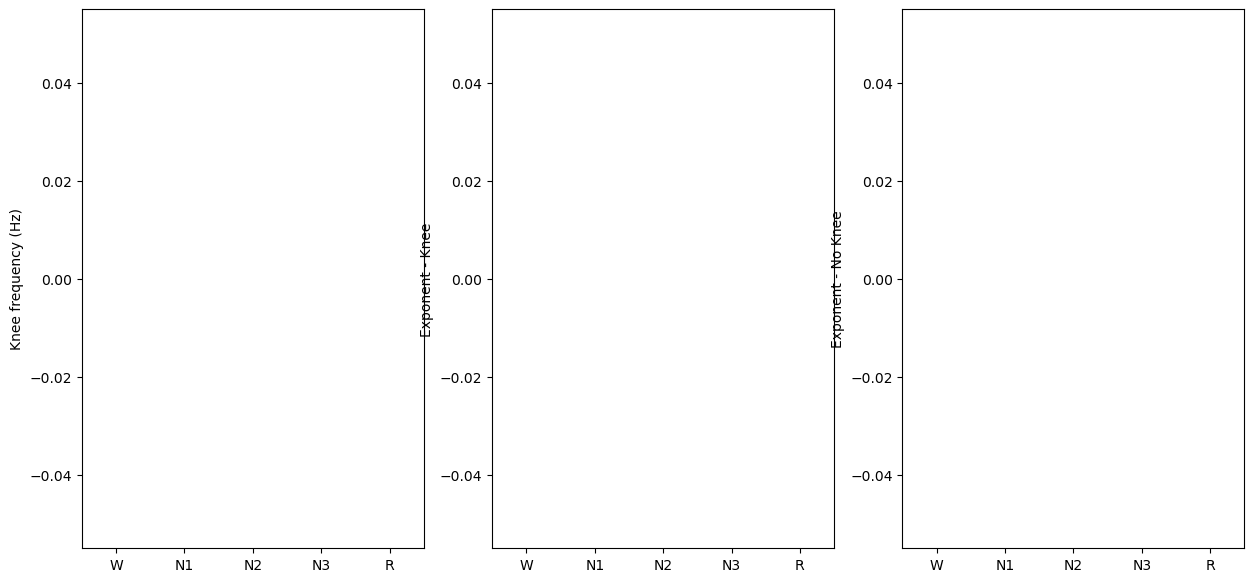

In [8]:
array_list2 = [np.nanmean(Kn_W,1),np.nanmean(Kn_N1,1), np.nanmean(Kn_N2,1), np.nanmean(Kn_N3,1), np.nanmean(Kn_R,1)]
array_list3 = [np.nanmean(W_Exp,1), np.nanmean(N1_Exp,1), np.nanmean(N2_Exp,1), np.nanmean(N3_Exp,1), np.nanmean(R_Exp,1)]
array_list4 = [np.nanmean(W_Exp2,1), np.nanmean(N1_Exp2,1), np.nanmean(N2_Exp2,1), np.nanmean(N3_Exp2,1), np.nanmean(R_Exp2,1)]

titles =  ['W','N1', 'N2','N3','R']

fig = plt.figure(figsize=(15, 7))  

ax = fig.add_subplot(1, 3, 1)

ax = seaborn.swarmplot(data=array_list2)
ax.set( ylabel='Knee frequency (Hz)')
ax.set_xticklabels(titles)
seaborn.scatterplot(x=[0,1,2,3,4], y=np.nanmean(array_list2,1), marker='X', color='black', s=100, zorder=4, legend=False);
plt.plot([array_list2[0], array_list2[1], array_list2[2], array_list2[3],array_list2[4]], color = 'grey', linewidth = 0.5);

ax = fig.add_subplot(1, 3, 2)
ax = seaborn.swarmplot(data=array_list3)
ax.set( ylabel='Exponent - Knee')
ax.set_xticklabels(titles)
seaborn.scatterplot(x=[0,1,2,3,4], y=np.nanmean(array_list3,1), marker='X', color='black', s=100, zorder=4, legend=False);
plt.plot([array_list3[0], array_list3[1], array_list3[2], array_list3[3], array_list3[4]], color = 'grey', linewidth = 0.5);

ax = fig.add_subplot(1, 3, 3)
ax = seaborn.swarmplot(data=array_list4)
ax.set( ylabel='Exponent - No Knee')
ax.set_xticklabels(titles)
seaborn.scatterplot(x=[0,1,2,3,4], y=np.nanmean(array_list4,1), marker='X', color='black', s=100, zorder=4, legend=False);
plt.plot([array_list4[0], array_list4[1], array_list4[2], array_list4[3],array_list4[4]], color = 'grey', linewidth = 0.5);



# 30 - 45 Hz

In [78]:
# Settings for the analyses
SETTINGS_B = { 'method' : 'welch', 'average' : 'mean', 'fmin' :0.1, 'fmax': 45}
path_results = Path('/home/b1044271/Columbia/Results/April23')

f_min = 30
f_max = 45
t     = 15
fs    = 250

SETTINGS_W  = { 'method' : 'welch', 'average' : 'mean', 'fmin' :f_min , 'fmax':f_max, 'n_fft': fs*t, 'n_overlap': fs*t*0.5}
SETTINGS_F2 = {'max_n_peaks':8, 'aperiodic_mode':'fixed'}
SETTINGS_F1 = {'max_n_peaks':8, 'aperiodic_mode':'knee'}

In [ ]:
# PATHS
# get the staging list
path_stage = Path('/home/b1044271/EEGsleep/SleepStaging/mat/mne2/')
stage_files = os.listdir(path_stage)
stage_files = [file for file in stage_files]
stage_files = sorted(stage_files)

# get the subjects list
Data_path = '/home/b1044271/Columbia/Preprocessed/Better_ica/'
subj_files = os.listdir(Data_path)
subj_files = [file for file in subj_files]
subj_files = sorted(subj_files)


In [79]:

W_Exp3 = np.zeros([183,2000])*np.nan
W_Exp3K = np.zeros([183,2000])*np.nan

N1_Exp3 = np.zeros([183,2000])*np.nan
N1_Exp3K = np.zeros([183,2000])*np.nan

N2_Exp3 = np.zeros([183,2000])*np.nan
N2_Exp3K = np.zeros([183,2000])*np.nan

N3_Exp3 = np.zeros([183,2000])*np.nan
N3_Exp3K = np.zeros([183,2000])*np.nan


R_Exp3 = np.zeros([183,2000])*np.nan
R_Exp3K = np.zeros([183,2000])*np.nan


In [81]:
# Helper function for paths, check for the path and creates ones if not found
def check_path(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [85]:
# Start function
i = 0
for x in subj_files:
    #check_path(path_results / x[0:4]) # create subject folder
    EEG = mne.io.read_raw_eeglab(os.path.join(Data_path, x)) # read raw .set file
    print('loaded')
    
    events = mne.read_events(Path(path_stage, stage_files[i])) #read staging markers
    epochs = mne.Epochs(EEG, events=events, tmin=-30, tmax=0)

#Now we select epochs and average over all epochs
    N1s = epochs['1']
    N2s = epochs['2']
    N3s = epochs['3']
    REs = epochs['5']
    AWs = epochs['0']
    
# Settings for PSD calculation using welch's
    N1={}
    N2={}
    N3={}
    AW={}
    RM={}

# calculate psd based on welch's method with differen freq range and diff time steps
    N1 = N1s.compute_psd(**SETTINGS_W) #N1
    N2 = N2s.compute_psd(**SETTINGS_W) #N2
    N3 = N3s.compute_psd(**SETTINGS_W)
    AW = AWs.compute_psd(**SETTINGS_W)
    RM = REs.compute_psd(**SETTINGS_W)
    
# FOOOF it
  
    fm6 = FOOOFGroup(**SETTINGS_F2)
    fm6.fit(N1._freqs, np.mean(N1._data,0), [N1._freqs[0] ,N1._freqs[-1]])
    
    fm7 = FOOOFGroup(**SETTINGS_F2)
    fm7.fit(N2._freqs, np.mean(N2._data,0), [N2._freqs[0] ,N2._freqs[-1]])
 
    fm8 = FOOOFGroup(**SETTINGS_F2)
    fm8.fit(N3._freqs, np.mean(N3._data,0), [N3._freqs[0] ,N3._freqs[-1]])
    
    fm9 = FOOOFGroup(**SETTINGS_F2)
    fm9.fit(RM._freqs, np.mean(RM._data,0), [RM._freqs[0] ,RM._freqs[-1]])
    
    fm10 = FOOOFGroup(**SETTINGS_F2)
    fm10.fit(AW._freqs, np.mean(AW._data,0), [AW._freqs[0] ,AW._freqs[-1]])
    
# parameters exctraction
    W_Exp3[i,0:AW._data.shape[1]] = fm10.get_params('aperiodic_params','exponent')
  
    R_Exp3[i,0:RM._data.shape[1]] = fm9.get_params('aperiodic_params','exponent')

    N1_Exp3[i,0:N1._data.shape[1]] = fm6.get_params('aperiodic_params','exponent')
 
    N2_Exp3[i,0:N2._data.shape[1]] = fm7.get_params('aperiodic_params','exponent')

    N3_Exp3[i,0:N3._data.shape[1]] = fm8.get_params('aperiodic_params','exponent') 
   
    i = i+1

loaded
Not setting metadata
927 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 85 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 465 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 140 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 75 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 161 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup ac

Using data from preloaded Raw for 146 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
loaded
Not setting metadata
935 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 61 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 381 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 245 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 63 events and 7501 original tim

0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 420 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 54 events and 7501 original time points ...
1 bad epochs dropped
Effective window size : 15.000 (s)
Using data from preloaded Raw for 131 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
Running FOOOFGroup across 183 power spectra.
loaded
Not setting metadata
991 matching events found
Setting baseline interval to [-30.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 113 events and 7501 original time points ...
0 bad epochs dropped
Effective window size : 15.000 (s)
Using dat

In [98]:
result_path = '/home/b1044271/Columbia/Results/Paper'

np.save(result_path + '/Exp_nKnee_t15_F3045_W.npy',W_Exp3)
np.save(result_path + '/Exp_nKnee_t15_F3045_N1.npy',N1_Exp3)
np.save(result_path + '/Exp_nKnee_t15_F3045_N2.npy',N2_Exp3)
np.save(result_path + '/Exp_nKnee_t15_F3045_N3.npy',N3_Exp3)
np.save(result_path + '/Exp_nKnee_t15_F3045_R.npy',R_Exp3)

# NOW LOADING THE RESULTS OF THE 30-45 SIMPLE MODEL FIT

In [76]:
Exp_AW = np.zeros(17)*np.nan
Exp_N1 = np.zeros(17)*np.nan
Exp_N2 = np.zeros(17)*np.nan
Exp_N3 = np.zeros(17)*np.nan
Exp_RM = np.zeros(17)*np.nan

path_files = '/home/b1044271/Columbia/Results/FOOOF_interp/30-45/'

Subject_folder = [name for name in os.listdir(path_files) if os.path.isdir(os.path.join(path_files, name))]


for i,subj in enumerate(Subject_folder):
    
    X = path_files + subj +  '/AW/NoKnee/*T15_30-45_NoKnee_8p.json'
    f = open(glob.glob(X)[0])
    data = json.load(f)
    Exp_AW[i] = data["aperiodic_params_"][1]
    
    
    X2 = path_files + subj +  '/N1/NoKnee/*T15_30-45_NoKnee_8p.json'
    f2 = open(glob.glob(X2)[0])
    data2 = json.load(f2)
    Exp_N1[i] = data2["aperiodic_params_"][1]
    
    X3 = path_files + subj +  '/N2/NoKnee/*T15_30-45_NoKnee_8p.json'
    f3 = open(glob.glob(X3)[0])
    data3 = json.load(f3)
    Exp_N2[i] = data3["aperiodic_params_"][1]
    
    X4 = path_files + subj +  '/N3/NoKnee/*T15_30-45_NoKnee_8p.json'
    f4 = open(glob.glob(X4)[0])
    data4 = json.load(f4)
    Exp_N3[i] = data4["aperiodic_params_"][1]
    
    X5 = path_files + subj +  '/RM/NoKnee/*T15_30-45_NoKnee_8p.json'
    f5 = open(glob.glob(X5)[0])
    data5 = json.load(f5)
    Exp_RM[i] = data5["aperiodic_params_"][1]

# LOAD THE SAVED DATA AND GO FOR THE ANALYSIS

In [4]:
path = '/home/b1044271/Columbia/Results/Slope_Knee_over_stages/New/'
# Exponent of the fixed model - 1-45Hz
Exp_W_nk_all = np.load(path + 'Exp_nKnee_t15_F45_W.npy')
Exp_N1_nk_all = np.load(path + 'Exp_nKnee_t15_F45_N1.npy')
Exp_N2_nk_all = np.load(path + 'Exp_nKnee_t15_F45_N2.npy')
Exp_N3_nk_all = np.load(path + 'Exp_nKnee_t15_F45_N3.npy')
Exp_R_nk_all = np.load(path + 'Exp_nKnee_t15_F45_R.npy')

# Exponent of the Kneed model - 1-45Hz
Exp_W_k_all = np.load(path + 'Exp_wKnee_t15_F45_W.npy')
Exp_N1_k_all = np.load(path + 'Exp_wKnee_t15_F45_N1.npy')
Exp_N2_k_all = np.load(path + 'Exp_wKnee_t15_F45_N2.npy')
Exp_N3_k_all = np.load(path + 'Exp_wKnee_t15_F45_N3.npy')
Exp_R_k_all = np.load(path + 'Exp_wKnee_t15_F45_R.npy')

#R2 of the fixed model - 1-45Hz
R2_W_nk_all = np.load(path + 'R2_nKnee_t15_F45_W.npy')
R2_N1_nk_all = np.load(path + 'R2_nKnee_t15_F45_N1.npy')
R2_N2_nk_all = np.load(path + 'R2_nKnee_t15_F45_N2.npy')
R2_N3_nk_all = np.load(path + 'R2_nKnee_t15_F45_N3.npy')
R2_R_nk_all = np.load(path + 'R2_nKnee_t15_F45_R.npy')

# R2 of the Kneed model - 1-45Hz
R2_W_k_all = np.load(path + 'R2_Knee_t15_F45_W.npy')
R2_N1_k_all = np.load(path + 'R2_Knee_t15_F45_N1.npy')
R2_N2_k_all = np.load(path + 'R2_Knee_t15_F45_N2.npy')
R2_N3_k_all = np.load(path + 'R2_Knee_t15_F45_N3.npy')
R2_R_k_all = np.load(path + 'R2_Knee_t15_F45_R.npy')

# Knee frequency of the Knee model - 30-45Hz
K_W = np.load(path + 'Kn_t15_F45_W.npy')
K_N1 = np.load(path + 'Kn_t15_F45_N1.npy')
K_N2 = np.load(path + 'Kn_t15_F45_N2.npy')
K_N3 = np.load(path + 'Kn_t15_F45_N3.npy')
K_R= np.load(path + 'Kn_t15_F45_R.npy')

# Frequency
Freqs = np.load('/home/b1044271/Columbia/Results/PSDs/Freqs/T5F45_freqres.npy')

# Exponent of the fixed model - 1-45Hz
E_W_nk_all = np.load(path + 'E_nKnee_t15_F45_W.npy')
E_N1_nk_all = np.load(path + 'E_nKnee_t15_F45_N1.npy')
E_N2_nk_all = np.load(path + 'E_nKnee_t15_F45_N2.npy')
E_N3_nk_all = np.load(path + 'E_nKnee_t15_F45_N3.npy')
E_R_nk_all = np.load(path + 'E_nKnee_t15_F45_R.npy')

# Exponent of the Kneed model - 1-45Hz
E_W_k_all = np.load(path + 'E_Knee_t15_F45_W.npy')
E_N1_k_all = np.load(path + 'E_Knee_t15_F45_N1.npy')
E_N2_k_all = np.load(path + 'E_Knee_t15_F45_N2.npy')
E_N3_k_all = np.load(path + 'E_Knee_t15_F45_N3.npy')
E_R_k_all = np.load(path + 'E_Knee_t15_F45_R.npy')

# Exponent of the Fixed model - 30-45Hz
#Exp_W_nk_30 = np.load(path + 'Exp_nKnee_t15_F3045_W.npy')
#Exp_N1_nk_30 = np.load(path + 'Exp_nKnee_t15_F3045_N1.npy')
#Exp_N2_nk_30 = np.load(path + 'Exp_nKnee_t15_F3045_N2.npy')
#Exp_N3_nk_30 = np.load(path + 'Exp_nKnee_t15_F3045_N3.npy')
#Exp_R_nk_30 = np.load(path + 'Exp_nKnee_t15_F3045_R.npy')

# COMPARE KNEE AND FIXED MODELS

In [5]:
# Import Custom functions for BIC calculation
from utils import calculate_bic

# EMPTY VECTORS
BIC_NK_W = np.zeros(len(E_R_nk_all))*np.nan
BIC_K_W = np.zeros(len(E_R_k_all))*np.nan
BIC_NK_N1 = np.zeros(len(E_R_nk_all))*np.nan
BIC_K_N1 = np.zeros(len(E_R_k_all))*np.nan
BIC_NK_N2 = np.zeros(len(E_R_nk_all))*np.nan
BIC_K_N2 = np.zeros(len(E_R_k_all))*np.nan
BIC_NK_N3 = np.zeros(len(E_R_nk_all))*np.nan
BIC_K_N3 = np.zeros(len(E_R_k_all))*np.nan
BIC_NK_R = np.zeros(len(E_R_nk_all))*np.nan
BIC_K_R = np.zeros(len(E_R_k_all))*np.nan

# set parameters

n = len(Freqs) #0.5hz frequency resolution to 45
num_params_nk = 26  # I modelled 8 peaks *3 = 24 and + 2 aperiodic parameter (slope + offset)
num_params_k = num_params_nk + 1# added the knee to aperiodic parameters (8 peasks + 3 aperiodic params)

# BIC Per subject
for i in np.arange(len(Exp_R_nk_all)):

    BIC_NK_W[i] = calculate_bic(n, np.nanmean(E_W_nk_all[i], axis=0), num_params_nk)
    BIC_K_W[i] = calculate_bic(n, np.nanmean(E_W_k_all[i], axis=0), num_params_k)
    
    BIC_NK_N1[i] = calculate_bic(n, np.nanmean(E_N1_nk_all[i], axis=0), num_params_nk)
    BIC_K_N1[i] = calculate_bic(n, np.nanmean(E_N1_k_all[i], axis=0), num_params_k)#
    
    BIC_NK_N2[i] = calculate_bic(n, np.nanmean(E_N2_nk_all[i], axis=0), num_params_nk)
    BIC_K_N2[i] = calculate_bic(n, np.nanmean(E_N2_k_all[i], axis=0), num_params_k)
    
    BIC_NK_N3[i] = calculate_bic(n, np.nanmean(E_N3_nk_all[i], axis=0), num_params_nk)
    BIC_K_N3[i] = calculate_bic(n, np.nanmean(E_N3_k_all[i], axis=0), num_params_k)
    
    BIC_NK_R[i] = calculate_bic(n, np.nanmean(E_R_nk_all[i], axis=0), num_params_nk)
    BIC_K_R[i] = calculate_bic(n, np.nanmean(E_R_k_all[i], axis=0), num_params_k)
    

# Perform stats on Model fit estimates (BIC)

In [6]:
# Import custom project code
from utils import pairwise_comparison

In [7]:
NK_BIC = np.reshape([BIC_NK_W,BIC_NK_N1,BIC_NK_N2,BIC_NK_N3,BIC_NK_R],((17*5)))
K_BIC  = np.reshape([BIC_K_W,BIC_K_N1,BIC_K_N2,BIC_K_N3,BIC_K_R],((17*5)))

#NK_BIC2 = NK_BIC**2
#K_BIC2 = K_BIC**2       

In [8]:
data = {'BIC_K_NK' : np.reshape([K_BIC, NK_BIC],(17*10)),
       'X' : np.repeat(["knee","fixed"], 17*5,axis=0),
       'Stages' : np.repeat(['Wake','N1','N2','N3','REM','Wake','N1','N2','N3','REM'], 17, axis=0)}

df = pd.DataFrame(data)

array_list_BIC = [K_BIC, NK_BIC]

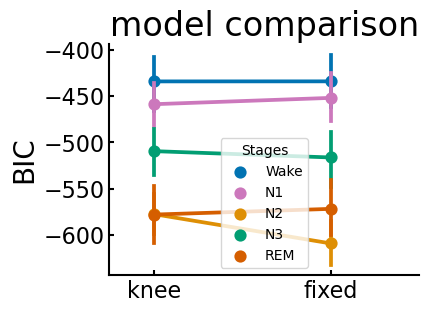

In [9]:
import seaborn as sns
#titles = ['Knee M', 'Fixed M']
ColStage = [seaborn.color_palette("colorblind")[0], seaborn.color_palette("colorblind")[4],
            seaborn.color_palette("colorblind")[1], 
        seaborn.color_palette("colorblind")[2],seaborn.color_palette("colorblind")[3]]


ax = plt.figure(figsize=(4,3))  

ax = sns.pointplot(data=df, x='X', y="BIC_K_NK", hue = 'Stages', palette = ColStage)
ax.set( ylabel='Knee frequency (Hz)')
#ax.set_xticklabels(titles)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('BIC',fontsize=20)
plt.xlabel('')
#plt.plot([array_list_BIC[0], array_list_BIC[1]], color = 'grey', linewidth = 0.5, linestyle = '-')
plt.xlim(-0.25,1.5)
plt.title('model comparison', fontsize = 24)
#seaborn.scatterplot(x=[0,1], y=[np.mean(K_BIC), np.mean(NK_BIC)], marker='X', color='black', s=200, zorder=4, legend=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

#plt.savefig("/home/b1044271/Columbia/Plots/NOV23/EEG_ModelComparison_av.svg", dpi = 600 )


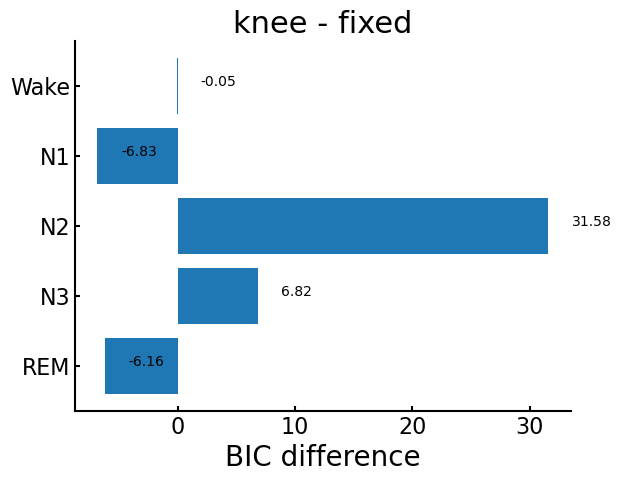

In [10]:
# Fixing random state for reproducibility
fig, ax = plt.subplots()

diff = [np.nanmean(BIC_K_W)-np.nanmean(BIC_NK_W),np.nanmean(BIC_K_N1)-np.nanmean(BIC_NK_N1),
 np.nanmean(BIC_K_N2)-np.nanmean(BIC_NK_N2),np.nanmean(BIC_K_N3)-np.nanmean(BIC_NK_N3),np.nanmean(BIC_K_R)-np.nanmean(BIC_NK_R)]
# Example data
Stages = ('Wake', 'N1', 'N2', 'N3', 'REM')
y_pos = np.arange(len(Stages))

ax.barh(y_pos, diff, align='center')
ax.set_yticks(y_pos, labels=Stages)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('BIC difference', fontsize = 20)
ax.set_title('knee - fixed', fontsize = 22)

for index, value in enumerate(diff):
    plt.text(value +2, index,
             str(np.round(value,2)))


plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

#plt.savefig("/home/b1044271/Columbia/Plots/NOV23/EEG_ModelComparison_bar.svg", dpi = 600 )

# PLOTTING THE DIFFERENCE BETWEEN STAGES

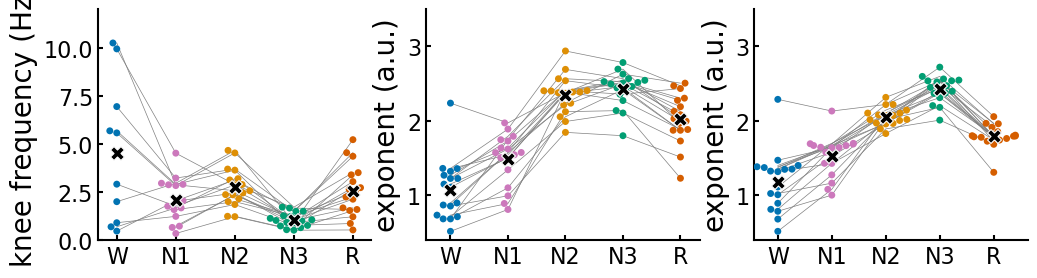

In [11]:
array_list2 = [np.nanmean(Exp_W_nk_all,1),np.nanmean(Exp_N1_nk_all,1), np.nanmean(Exp_N2_nk_all,1), np.nanmean(Exp_N3_nk_all,1), np.nanmean(Exp_R_nk_all,1)]
array_list3 = [np.nanmean(Exp_W_k_all,1),np.nanmean(Exp_N1_k_all,1), np.nanmean(Exp_N2_k_all,1), np.nanmean(Exp_N3_k_all,1), np.nanmean(Exp_R_k_all,1)]
#array_list4 = [np.nanmean(Exp_W_nk_30,1),np.nanmean(Exp_N1_nk_30,1), np.nanmean(Exp_N2_nk_30,1), np.nanmean(Exp_N3_nk_30,1), np.nanmean(Exp_R_nk_30,1)]
array_list5 = [np.nanmean(K_W,1),np.nanmean(K_N1,1), np.nanmean(K_N2,1), np.nanmean(K_N3,1), np.nanmean(K_R,1)]

import seaborn as sns
titles =  ['W','N1', 'N2','N3','R']
fig = plt.figure(figsize=(12, 3))  
ColStage = [seaborn.color_palette("colorblind")[0], seaborn.color_palette("colorblind")[4],
            seaborn.color_palette("colorblind")[1], 
        seaborn.color_palette("colorblind")[2],seaborn.color_palette("colorblind")[3]]

ax = fig.add_subplot(1, 3, 1)
ax = seaborn.swarmplot(data=array_list5,palette = ColStage)
ax.set_xticklabels(titles, fontsize = 20)
seaborn.scatterplot(x=[0,1,2,3,4], y=np.nanmean(array_list5,1), marker='X', color='black', s=100, zorder=4, legend=False);
plt.plot([array_list5[0], array_list5[1], array_list5[2], array_list5[3],array_list5[4]], color = 'grey', linewidth = 0.5);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0., 12])
plt.ylabel('knee frequency (Hz)', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

ax = fig.add_subplot(1, 3, 2)
ax = seaborn.swarmplot(data=array_list3,  palette = ColStage)
ax.set_xticklabels(titles, fontsize = 20)
seaborn.scatterplot(x=[0,1,2,3,4], y=np.nanmean(array_list3,1), marker='X', color='black', s=100, zorder=4, legend=False);
plt.plot([array_list3[0], array_list3[1], array_list3[2], array_list3[3], array_list3[4]], color = 'grey', linewidth = 0.5);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('exponent (a.u.)', fontsize=20)
plt.ylim([0.4, 3.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

ax = fig.add_subplot(1, 3, 3)
ax = seaborn.swarmplot(data=array_list2, palette=ColStage)
ax.set_xticklabels(titles, fontsize = 20)
seaborn.scatterplot(x=[0,1,2,3,4], y=np.nanmean(array_list2,1), marker='X', color='black', s=100, zorder=4, legend=False);
plt.plot([array_list2[0], array_list2[1], array_list2[2], array_list2[3],array_list2[4]], color = 'grey', linewidth = 0.5);
plt.ylabel('exponent (a.u.)', fontsize=20)
plt.ylim([0.4, 3.5])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

#plt.savefig("/home/b1044271/Columbia/Plots/NOV23/EEG_slope_knee.svg", dpi = 600)

## PLOT R2

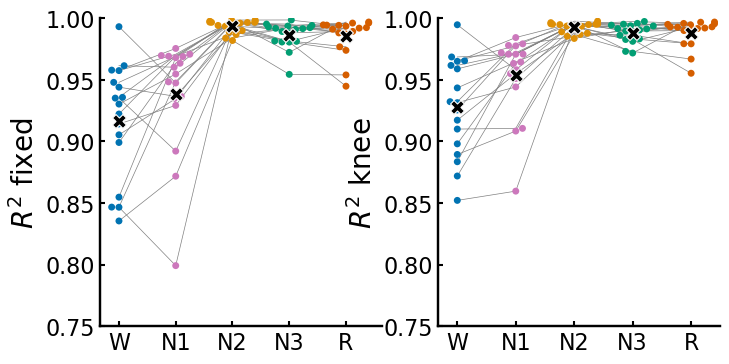

In [43]:
array_list2r = [np.nanmean(R2_W_nk_all,1),np.nanmean(R2_N1_nk_all,1), np.nanmean(R2_N2_nk_all,1), np.nanmean(R2_N3_nk_all,1), np.nanmean(R2_R_nk_all,1)]
array_list3r = [np.nanmean(R2_W_k_all,1),np.nanmean(R2_N1_k_all,1), np.nanmean(R2_N2_k_all,1), np.nanmean(R2_N3_k_all,1), np.nanmean(R2_R_k_all,1)]


fig = plt.figure(figsize=(8, 4))  


ax = fig.add_subplot(1, 2, 1)
ax = seaborn.swarmplot(data=array_list2r,palette = ColStage)
ax.set_xticklabels(titles, fontsize = 20)
seaborn.scatterplot(x=[0,1,2,3,4], y=np.nanmean(array_list2r,1), marker='X', color='black', s=100, zorder=4, legend=False);
plt.plot([array_list2r[0], array_list2r[1], array_list2r[2], array_list2r[3],array_list2r[4]], color = 'grey', linewidth = 0.5);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([0.75, 1])
plt.ylabel('$R^2$ fixed', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)

ax = fig.add_subplot(1, 2, 2)
ax = seaborn.swarmplot(data=array_list3r,  palette = ColStage)
ax.set_xticklabels(titles, fontsize = 20)
seaborn.scatterplot(x=[0,1,2,3,4], y=np.nanmean(array_list3r,1), marker='X', color='black', s=100, zorder=4, legend=False);
plt.plot([array_list3r[0], array_list3r[1], array_list3r[2], array_list3r[3], array_list3r[4]], color = 'grey', linewidth = 0.5);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('$R^2$ knee', fontsize=20)
plt.ylim([0.75, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)


plt.savefig("/home/b1044271/Columbia/Plots/NOV23/EEG_slope_knee_R2.svg", dpi = 600)

# Perform stats on the stage differences

In [123]:
# Import custom project code
from utils import compute_z_values, compute_cliffs_delta, bonferroni_correction, friedman_dunns

# Plotting tables
from pandas.plotting import table 


In [139]:
from scipy.stats import norm
def compute_z_values(p_values):
    """
    Calculate z-values from Dunn's test p-values.

    Parameters:
    - p_values: Array of p-values from pairwise comparisons.

    Returns:
    - Array of z-values.
    """
    # Ensure p-values are within the valid range [0, 1]
    p_values = np.clip(p_values, np.finfo(float).eps, 1 - np.finfo(float).eps)

    # Calculate two-sided z-values
    z_values = norm.ppf(1 - p_values / 2)

    return z_values

In [148]:
from cliffs_delta import cliffs_delta 

effect_sizes2 = pd.DataFrame(index=data.columns, columns=data.columns)
for i, col1 in enumerate(data.columns):
    for j, col2 in enumerate(data.columns):
        if i < j:
            cd.loc[col1, col2] = cliffs_delta(data[col1], data[col2])[0]
            cd.loc[col2, col1] = -effect_sizes2.loc[col1, col2]

array([[-0.77854671,  0.29411765,  1.        ,  1.        ,  1.        ],
       [-1.        , -0.12456747, -0.10034602,  0.62629758,  0.02422145],
       [-1.        ,  0.01730104,  0.        ,  0.92387543,  0.12802768],
       [-1.        , -0.62629758, -0.92387543,  0.        , -0.73010381],
       [-1.        , -0.10726644, -0.12802768,  0.73010381,  0.        ]])

In [154]:
cliffs_delta(array_list5[1],array_list5[4])

(0.02422145328719723, 'negligible')

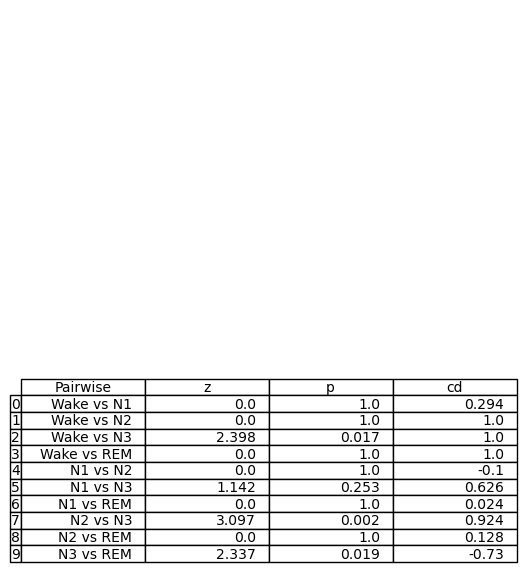

In [157]:
# KNEE - STATS
data = pd.DataFrame(np.transpose(array_list5))

friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)

z_values2 = compute_z_values(corrected_p_values)


effect_sizes2 = pd.DataFrame(index=data.columns, columns=data.columns)
for i, col1 in enumerate(data.columns):
    for j, col2 in enumerate(data.columns):
        if i < j:
            effect_sizes2.loc[col1, col2] = cliffs_delta(data[col1], data[col2])[0]
            effect_sizes2.loc[col2, col1] = -effect_sizes2.loc[col1, col2]


# MAKE STAT TABLE

compute_cliffs_delta(array_list5[0],array_list5[1])

#add the relevant pairwise comaprisons
x = pd.DataFrame.to_numpy(corrected_p_values)
x2 = x.reshape(len(x)*len(x))
idx = [1,2,3,4,7,8,9,13,14,19] 
x3 = x2[idx]


y = pd.DataFrame.to_numpy(effect_sizes2)
y2 = y.reshape(len(y)*len(y))
y3 = y2[idx]
y3 = y3.astype(float)

z2 = z_values2.reshape(len(z_values)*len(z_values))
z3 = z2[idx]

# create an array with the names of the pairwise comparisons
pairwise_tests = ['Wake vs N1', 'Wake vs N2', 'Wake vs N3', 'Wake vs REM',  # WAKE
                     'N1 vs N2', 'N1 vs N3', 'N1 vs REM',      # N1
                          'N2 vs N3' , 'N2 vs REM',   # N2
                       'N3 vs REM']  # REM

# create dataframe
data = {'Pairwise' : pairwise_tests,'z' : np.round(z3,3),'p' : np.round(x3,3),'cd' : np.round(y3,3)}

stat_df = pd.DataFrame(data)
stat_df.style.set_properties(**{'text-align': 'centre'})

# PLOTTING the table
ax = plt.subplot(111, frame_on=False) # no visible frame
table(ax, stat_df)  # where df is your data frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
plt.savefig('/home/b1044271/Columbia/Plots/NOV23/Stats/EEG_KneeFreq_STATS.svg')

In [158]:
from cliffs_delta import cliffs_delta 
cliffs_delta(array_list5[1],array_list5[3])

(0.6262975778546713, 'large')

In [159]:
corrected_p_values

,0,1,2,3,4
0,1.000000,1.000000,1.000000,0.016504,1.000000
1,1.000000,1.000000,1.000000,0.253291,1.000000
2,1.000000,1.000000,1.000000,0.001958,1.000000
3,0.016504,0.253291,0.001958,1.000000,0.019415
4,1.000000,1.000000,1.000000,0.019415,1.000000


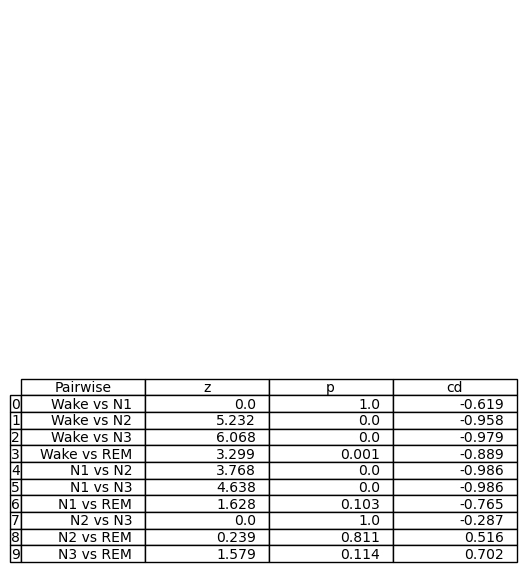

In [160]:
# EXP K - STATS
data = pd.DataFrame(np.transpose(array_list3))

friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)
z_values2 = compute_z_values(corrected_p_values)


effect_sizes2 = pd.DataFrame(index=data.columns, columns=data.columns)
for i, col1 in enumerate(data.columns):
    for j, col2 in enumerate(data.columns):
        if i < j:
            effect_sizes2.loc[col1, col2] = cliffs_delta(data[col1], data[col2])[0]
            effect_sizes2.loc[col2, col1] = -effect_sizes2.loc[col1, col2]



# MAKE STAT TABLE

#add the relevant pairwise comaprisons
x = pd.DataFrame.to_numpy(corrected_p_values)
x2 = x.reshape(len(x)*len(x))
idx = [1,2,3,4,7,8,9,13,14,19] 
x3 = x2[idx]


y = pd.DataFrame.to_numpy(effect_sizes2)
y2 = y.reshape(len(y)*len(y))
y3 = y2[idx]
y3 = y3.astype(float)

z2 = z_values2.reshape(len(z_values)*len(z_values))
z3 = z2[idx]

# create an array with the names of the pairwise comparisons
pairwise_tests = ['Wake vs N1', 'Wake vs N2', 'Wake vs N3', 'Wake vs REM',  # WAKE
                     'N1 vs N2', 'N1 vs N3', 'N1 vs REM',      # N1
                          'N2 vs N3' , 'N2 vs REM',   # N2
                       'N3 vs REM']  # REM

# create dataframe
data = {'Pairwise' : pairwise_tests,'z' : np.round(z3,3),'p' : np.round(x3,3),'cd' : np.round(y3,3)}

stat_df = pd.DataFrame(data)

# PLOTTING the table
ax = plt.subplot(111, frame_on=False) # no visible frame
table(ax, stat_df)  # where df is your data frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
plt.savefig('/home/b1044271/Columbia/Plots/NOV23/Stats/EEG_ExpKnee_STATS.svg')

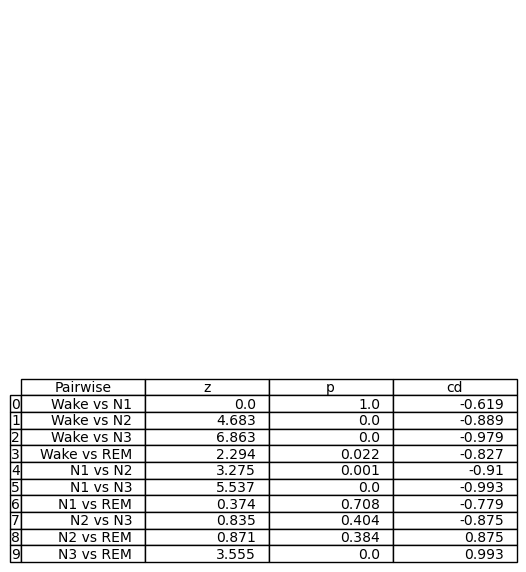

In [161]:
# Exp No KNEE - STATS
data = pd.DataFrame(np.transpose(array_list2))

friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)
z_values2 = compute_z_values(corrected_p_values)

effect_sizes2 = pd.DataFrame(index=data.columns, columns=data.columns)
for i, col1 in enumerate(data.columns):
    for j, col2 in enumerate(data.columns):
        if i < j:
            effect_sizes2.loc[col1, col2] = cliffs_delta(data[col1], data[col2])[0]
            effect_sizes2.loc[col2, col1] = -effect_sizes2.loc[col1, col2]



# MAKE STAT TABLE

#add the relevant pairwise comaprisons
x = pd.DataFrame.to_numpy(corrected_p_values)
x2 = x.reshape(len(x)*len(x))
idx = [1,2,3,4,7,8,9,13,14,19] 
x3 = x2[idx]


y = pd.DataFrame.to_numpy(effect_sizes2)
y2 = y.reshape(len(y)*len(y))
y3 = y2[idx]
y3 = y3.astype(float)

z2 = z_values2.reshape(len(z_values)*len(z_values))
z3 = z2[idx]

# create an array with the names of the pairwise comparisons
pairwise_tests = ['Wake vs N1', 'Wake vs N2', 'Wake vs N3', 'Wake vs REM',  # WAKE
                     'N1 vs N2', 'N1 vs N3', 'N1 vs REM',      # N1
                          'N2 vs N3' , 'N2 vs REM',   # N2
                       'N3 vs REM']  # REM

# create dataframe
data = {'Pairwise' : pairwise_tests,'z' : np.round(z3,3),'p' : np.round(x3,3),'cd' : np.round(y3,3)}

stat_df = pd.DataFrame(data)

# PLOTTING the table
ax = plt.subplot(111, frame_on=False) # no visible frame
table(ax, stat_df)  # where df is your data frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
plt.savefig('/home/b1044271/Columbia/Plots/NOV23/Stats/EEG_ExpFixed_STATS.svg')